In [1]:
import cv2
import pickle
import camutils
from camutils import Camera
from camutils import triangulate
from camutils import calibratePose
from camutils import reconstruct
import meshutils
import visutils
import numpy as np
import matplotlib.pyplot as plt
import trimesh


In [2]:
# load in the intrinsic camera parameters from 'calibration.pickle'
file = open('calibration.pickle','rb')
object_file = pickle.load(file)
fx,fy,cx,cy,dist  = object_file['fx'],object_file['fy'],object_file['cx'],object_file['cy'],object_file['dist']



Camera : 
 f=1404.6009664593485 
 c=[[962.16736834 590.91595778]] 
 R=[[ 0.03843674  0.98947411  0.13951198]
 [ 0.9773577  -0.00815434 -0.2114366 ]
 [-0.20807341  0.14448005 -0.96738357]] 
 t = [[ 6.86588564 19.5234718  47.34419111]]
Camera : 
 f=1404.6009664593485 
 c=[[962.16736834 590.91595778]] 
 R=[[-0.00259871  0.99096865  0.13406856]
 [ 0.99277874 -0.01352252  0.11919527]
 [ 0.11993172  0.13341017 -0.98377747]] 
 t = [[ 7.50010574  7.20925996 47.7649529 ]]


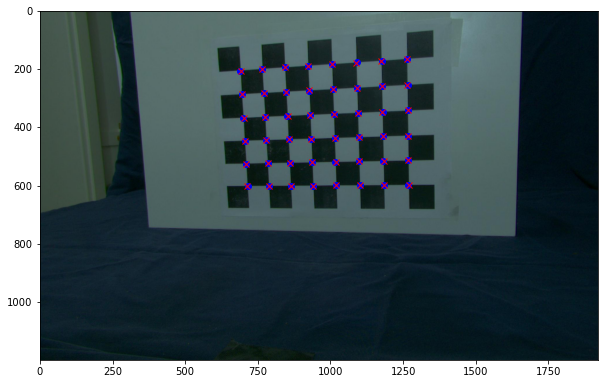

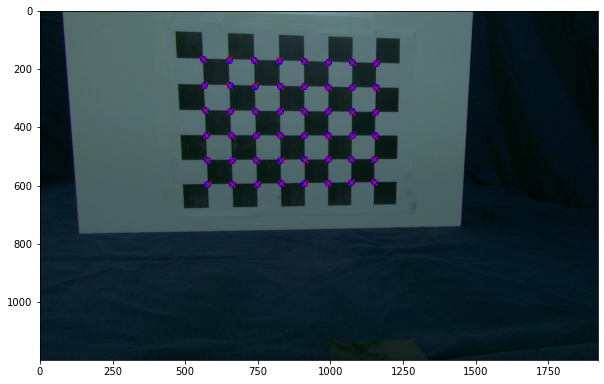

In [3]:
c = np.array([[cx],[cy]])
f = (fx+fy)/2

# create Camera objects representing the left and right cameras
# use the known intrinsic parameters you loaded in.
R = np.zeros((3,3))
t = np.zeros((3,1))
camL = Camera(f,c,R,t)
camR = Camera(f,c,R,t)

# load in the left and right images and find the coordinates of
# the chessboard corners using OpenCV
imgL = plt.imread('calib_jpg_u/frame_C0_01.jpg')
ret, cornersL = cv2.findChessboardCorners(imgL, (8,6), None)
pts2L = cornersL.squeeze().T

imgR = plt.imread('calib_jpg_u/frame_C1_01.jpg')
gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
ret, cornersR = cv2.findChessboardCorners(gray, (8,6), None)
pts2R = cornersR.squeeze().T

# generate the known 3D point coordinates of points on the checkerboard in cm
pts3 = np.zeros((3,6*8))
yy,xx = np.meshgrid(np.arange(8),np.arange(6))
pts3[0,:] = 2.8*xx.reshape(1,-1)
pts3[1,:] = 2.8*yy.reshape(1,-1)

# Now use your calibratePose function to get the extrinsic parameters
# for the two images. You may need to experiment with the initialization
# in order to get a good result

#calibratePose(pts3,pts2,cam,params_init)
params_init = np.array([0,0,0,0,1,-1]) 
camL = calibratePose(pts3,pts2L,camL,params_init)
camR = calibratePose(pts3,pts2R,camR,params_init)

print(camL)
print(camR)

# As a final test, triangulate the corners of the checkerboard to get back there 3D locations
pts3r = triangulate(pts2L,camL,pts2R,camR)

# Display the reprojected points overlayed on the images to make 
# sure they line up
plt.rcParams['figure.figsize']=[10,10]
pts2Lp = camL.project(pts3)
plt.imshow(imgL)
plt.plot(pts2Lp[0,:],pts2Lp[1,:],'bo')
plt.plot(pts2L[0,:],pts2L[1,:],'rx')
plt.show()

pts2Rp = camR.project(pts3)
plt.imshow(imgR)
plt.plot(pts2Rp[0,:],pts2Rp[1,:],'bo')
plt.plot(pts2R[0,:],pts2R[1,:],'rx')
plt.show()


In [4]:
#
# first view
#
imprefixC0 = 'couple/grab_0_u/frame_C0_'
imprefixC1 = 'couple/grab_0_u/frame_C1_'
colors = ['couple/grab_0_u/color_C0_00.png', 
          'couple/grab_0_u/color_C0_01.png',
          'couple/grab_0_u/color_C1_00.png',
          'couple/grab_0_u/color_C1_01.png']
threshold = 0.025
pts2L,pts2R,pts3,cpix = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR,colors)
boxlimits = np.array([-12,18,2,17,-30,-3])
trithresh = 2
tri, pts3, cpix = meshutils.pruning(boxlimits, trithresh, pts2L, pts2R, pts3, cpix)
pts3 = meshutils.smoothIt(tri, pts3,4)
#meshutils.writeply(pts3,cpix,tri,'first.ply')

#
# second view
#
imprefixC0 = 'couple/grab_1_u/frame_C0_'
imprefixC1 = 'couple/grab_1_u/frame_C1_'
colors = ['couple/grab_1_u/color_C0_00.png', 
          'couple/grab_1_u/color_C0_01.png',
          'couple/grab_1_u/color_C1_00.png',
          'couple/grab_1_u/color_C1_01.png']
threshold = 0.025
pts2L,pts2R,pts3,cpix = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR,colors)
boxlimits = np.array([-25,22,0,25,-35,10])
trithresh = 5
tri, pts3, cpix = meshutils.pruning(boxlimits, trithresh, pts2L, pts2R, pts3, cpix)
pts3 = meshutils.smoothIt(tri, pts3,4)
meshutils.writeply(pts3,cpix,tri,'second.ply')
#
# third view
#
imprefixC0 = 'couple/grab_2_u/frame_C0_'
imprefixC1 = 'couple/grab_2_u/frame_C1_'
colors = ['couple/grab_2_u/color_C0_00.png', 
          'couple/grab_2_u/color_C0_01.png',
          'couple/grab_2_u/color_C1_00.png',
          'couple/grab_2_u/color_C1_01.png']
threshold = 0.025

pts2L,pts2R,pts3,cpix = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR,colors)
boxlimits = np.array([-10,23,-10,22,-30,-10])
trithresh = 4
tri, pts3, cpix = meshutils.pruning(boxlimits, trithresh, pts2L, pts2R,pts3, cpix)
pts3 = meshutils.smoothIt(tri, pts3,4)
meshutils.writeply(pts3,cpix,tri,'third.ply')
#
# forth view
#
imprefixC0 = 'couple/grab_3_u/frame_C0_'
imprefixC1 = 'couple/grab_3_u/frame_C1_'
colors = ['couple/grab_3_u/color_C0_00.png', 
          'couple/grab_3_u/color_C0_01.png',
          'couple/grab_3_u/color_C1_00.png',
          'couple/grab_3_u/color_C1_01.png']
threshold = 0.025

pts2L,pts2R,pts3,cpix = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR,colors)
boxlimits = np.array([-15,21,0,18,-30,-8])
trithresh = 4
tri, pts3, cpix = meshutils.pruning(boxlimits, trithresh, pts2L, pts2R,pts3, cpix)
pts3 = meshutils.smoothIt(tri, pts3,4)
meshutils.writeply(pts3,cpix,tri,'forth.ply')
#
# fifth view
#
imprefixC0 = 'couple/grab_4_u/frame_C0_'
imprefixC1 = 'couple/grab_4_u/frame_C1_'
colors = ['couple/grab_4_u/color_C0_00.png', 
          'couple/grab_4_u/color_C0_01.png',
          'couple/grab_4_u/color_C1_00.png',
          'couple/grab_4_u/color_C1_01.png']
threshold = 0.025

pts2L,pts2R,pts3,cpix = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR,colors)
boxlimits = np.array([-8,21,0,18,-30,-8])
trithresh = 4
tri, pts3, cpix = meshutils.pruning(boxlimits, trithresh, pts2L, pts2R,pts3, cpix)
pts3 = meshutils.smoothIt(tri, pts3,4)
meshutils.writeply(pts3,cpix,tri,'fifth.ply')
#
# sixth view
#
imprefixC0 = 'couple/grab_5_u/frame_C0_'
imprefixC1 = 'couple/grab_5_u/frame_C1_'
colors = ['couple/grab_5_u/color_C0_00.png', 
          'couple/grab_5_u/color_C0_01.png',
          'couple/grab_5_u/color_C1_00.png',
          'couple/grab_5_u/color_C1_01.png']
threshold = 0.025

pts2L,pts2R,pts3,cpix = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR,colors)
boxlimits = np.array([-15,21,3,35,-30,-8])
trithresh = 4
tri, pts3, cpix = meshutils.pruning(boxlimits, trithresh, pts2L, pts2R,pts3, cpix)
pts3 = meshutils.smoothIt(tri, pts3,4)
meshutils.writeply(pts3,cpix,tri,'sixth.ply')
#
# seventh view
#
imprefixC0 = 'couple/grab_6_u/frame_C0_'
imprefixC1 = 'couple/grab_6_u/frame_C1_'
colors = ['couple/grab_6_u/color_C0_00.png', 
          'couple/grab_6_u/color_C0_01.png',
          'couple/grab_6_u/color_C1_00.png',
          'couple/grab_6_u/color_C1_01.png']
threshold = 0.025

pts2L,pts2R,pts3,cpix = reconstruct(imprefixC0,imprefixC1,threshold,camL,camR,colors)
boxlimits = np.array([13,22,-10,25,-30,-1])
trithresh = 2.5
tri, pts3, cpix = meshutils.pruning(boxlimits, trithresh, pts2L, pts2R,pts3, cpix)
pts3 = meshutils.smoothIt(tri, pts3, 4)
meshutils.writeply(pts3,cpix,tri,'seventh.ply')


loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )( 14 15 )( 16 17 )( 18 19 )

loading( 20 21 )( 22 23 )( 24 25 )( 26 27 )( 28 29 )( 30 31 )( 32 33 )( 34 35 )( 36 37 )( 38 39 )

loading( 0 1 )( 2 3 )( 4 5 )( 6 7 )( 8 9 )( 10 11 )( 12 13 )

#### 